# Countryside Survey

Countryside Survey is a unique study or ‘audit’ of the natural resources of the UK’s countryside. The Survey has been carried out at discrete intervals since 1978. The countryside is sampled and studied using rigorous scientific methods, allowing results to be compared with those from previous surveys. In this way the quantity and quality of change in our landscapes can be recorded and even the most gradual and subtle changes that occur in the UK’s countryside over time can be detected. This evidence is used to help form policies that influence management of the countryside, both now and in the future.

**Server** [/1.0/2069de82-619d-4751-9904-aec8500d07e6](https://data-eidc.ceh.ac.uk/1.0/2069de82-619d-4751-9904-aec8500d07e6)

**Documentation** <https://data-eidc.ceh.ac.uk/docs/cs>

### 🔒 Authentication

Create a token with [Data API Auth](https://data-eidc.ceh.ac.uk/authentication) with the following **LICENCES** (LICENCE_OGL)

## Step 1: Install dependencies

In [33]:
!pip install bng_latlon

%matplotlib inline

import math
import json
import pprint
import time
from io import BytesIO, StringIO

from latlon_to_bng import WGS84toOSGB36
from bng_to_latlon import OSGB36toWGS84
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rc
import numpy as np
import pandas
import requests

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

## Step 2: Set the token

**WARNING** do not share tokens publicly, get them from secure environment variables or secure files. You can revoke a token at anytime and set the expiry such that if you do intend to share a notebook you do not compromise your tokens.


Here is an example of how to read the token from a file, in Colab open Files tab and click "Mount Drive" button and you should be able to do something similar to the following.

In [2]:
import os
#os.listdir('drive/My Drive')
f = open('token.txt', "r")
token = f.read()

## Step 3: Request the data

The following are some functions which will allow you to fetch the data

In [3]:
url = 'https://data-eidc.ceh.ac.uk/1.0/2069de82-619d-4751-9904-aec8500d07e6'

# Go to here for more info on the endpoints https://data-eidc.ceh.ac.uk/docs/cs

# The /metadata endpoint

def metadata(params={}):
    res = requests.get(
        "{}/metadata".format(url),
        params=params,
        headers={
            "Authorization": "Bearer {}".format(token)
        }
    )
    return res.json()


# The /metadata/key/{key} endpoint

def key_values(key):
    res = requests.get(
        "{}/metadata/key/{}".format(url, key),
        headers={
            "Authorization": "Bearer {}".format(token)
        }
    )
    return res.json()


# The /data endpoint. Using POST over GET as it is easier to manipulate the body in python over the query parameters

def post(params):
    res = requests.post(
        "{}/data".format(url),
        data=json.dumps(params),
        headers={
            "Authorization": "Bearer {}".format(token),
            "Accept": "text/csv",
            "Content-Type": "application/json"
        }
    )
    if not res.ok:
        return res.content
    return pandas.read_csv(BytesIO(res.content))


## Metadata Request

The Countryside Survey Data API has a metadata endpoint which allows you to automate your scripts without the need for worrying about typos or if the metadata changes e.g. more data is added.

The metadata is derived from the data EIDC catalogue <https://catalogue.ceh.ac.uk/documents/2069de82-619d-4751-9904-aec8500d07e6>

Available tags: veget, habitat, soil, wat, river, mite,landscap, featur

In [4]:
# Example metadata query for all vegetation in the year 2007

metadata({
    "tags": ["veget"], #  read here: https://data-eidc.ceh.ac.uk/docs/cs?schema=16
    "years": ["2007"]
})

[{'acronym': 'vp',
  'columns': [{'name': 'YEAR', 'type': 'int64'},
   {'name': 'SQUARE', 'type': 'string'},
   {'name': 'PLOT', 'type': 'string'},
   {'name': 'AMALG_PTYPE', 'type': 'string'},
   {'name': 'BRC_NUMBER', 'type': 'float64'},
   {'name': 'BRC_NAMES', 'type': 'string'},
   {'name': 'NEST_LEVEL', 'type': 'float64'},
   {'name': 'ZERO_COVER', 'type': 'float64'},
   {'name': 'FIRST_COVER', 'type': 'float64'},
   {'name': 'TOTAL_COVER', 'type': 'float64'},
   {'name': 'PLOT_TYPE', 'type': 'string'},
   {'name': 'COUNTRY', 'type': 'string'},
   {'name': 'ENV_ZONE_2007', 'type': 'int64'},
   {'name': 'EZ_DESC_07', 'type': 'string'},
   {'name': 'WORDS', 'type': 'string'},
   {'name': 'TAG', 'type': 'string'},
   {'name': 'UID', 'type': 'string'},
   {'name': 'PARENT', 'type': 'string'}],
  'files': [{'columns': ['YEAR',
     'SQUARE_ID',
     'PLOT_ID',
     'AMALG_PTYPE',
     'BRC_NUMBER',
     'BRC_NAMES',
     'NEST_LEVEL',
     'ZERO_COVER',
     'FIRST_COVER',
     'TOTAL_

### Metadata breakdown

 key | description
 ---|---
`acronym` | Shorthand for datasets
`columns` | All the columns in the dataset, quicker than getting the data and interogating it, it also describe the format of each column
`files` | Each dataset has different files, if you want to know where the data originally came from. This also describes the columes of the data
`parent` | Each dataset is part of a parent dataset which you can go search for in the EIDC catalogue
`parent_title` | The title of the parent dataset
`tag` | A common tag for datasets which share similar data, this value is derived from the Catalogue
`title` | The title of the dataset in the catalogue
`uid` | The id of the dataset which you can use to find in the catalogue
`words` | Keywords from the title which may be useful for understanding the dataset without having to read all the metadata (alone)
`year` | The year the dataset was taken

### Merging datasets together

You can also merge datasets together, for example the `soil` and `vegetation`. The Data API will attempt to merge them together using a outer join on common column names. This might always be the desired dataset.

If you want to know what the dataset will attempt to merge run the metadata endpoint first and if you are happy continue

**WARNING** merging the with the `landscap` tag may result in a long wait or possible no result at all, this is a known issue and is being worked on. We suggest you query `landscap` seperatly

In [5]:
# Check to see if veget and soil merge will give the expected dataframe

res = metadata({
    "tags": ["veget", "soil"]
})

In [6]:
for value in res:
  print(value['year'], value['title'])

2007 Soil aggregate stability data from arable and grassland in Countryside Survey, Great Britain 2007 
2000 Soil invertebrate data 1998 [Countryside Survey]
2007 Soil invertebrate data 2007 [Countryside Survey]
2000 Soil metals data 1998 [Countryside Survey]
2007 Soil metals data 2007 [Countryside Survey]
1978 Soil physico-chemical properties 1978 [Countryside Survey]
2000 Soil physico-chemical properties 1998 [Countryside Survey]
2007 Soil physico-chemical properties 2007 [Countryside Survey]	
2007 Topsoil mineralisable nitrogen (mineral-N) data 2007 [Countryside Survey]
1978 Countryside Survey 1978 vegetation plot data
1990 Countryside Survey 1990 vegetation plot data
2000 Countryside Survey 1998 vegetation plot data
2007 Countryside Survey 2007 vegetation plot data


## Key Values

This endpoint lists all values for a given key which can be used for automation of your scripts, or to discover what values might be available

In [7]:
# Get all the years of the data

years = key_values('year')
years

['1978', '1984', '1990', '2000', '2007']

In [8]:
# Get all the tags of the data

tags = key_values('tag')
tags

['featur', 'habitat', 'landscap', 'mite', 'river', 'soil', 'veget', 'wat']

## Data endpoint

The data endpoint is where you can query the Data API to get the data in either JSON or CSV format. It automatically combines common data together and will attempt to merge datasets together. See metadata above for more info on this.

By way of example we have 3 seperate queries which will showcase some of the capabilities of the Countryside Survey Data API `/data` endpoint.

# locate 10x10 km CS square location on BNG

In [152]:
import pandas as pd
import seaborn as sn
import networkx as nx
#from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import collections
import matplotlib.pyplot as plt


sq_web_codes = pd.read_csv('CS_sq_web_codes_with_10km.csv')
sq_web_codes


,WEB_ID,E_2_FIG_10KM,N_2_FIG_10KM,OS_2_FIG_10KM
0,ZTHUIF,450000,1200000,HP 5000 0000
1,RZMHKP,460000,1210000,HP 6000 1000
2,AZFZMV,420000,1140000,HU 2000 4000
3,BBIJIG,420000,1170000,HU 2000 7000
4,LCLMLO,430000,1190000,HU 3000 9000
...,...,...,...,...
620,DKFVKM,580000,170000,TQ 8000 7000
621,VMLMLA,590000,140000,TQ 9000 4000
622,YXYWSS,590000,170000,TQ 9000 7000
623,OXVLRI,610000,160000,TR 1000 6000


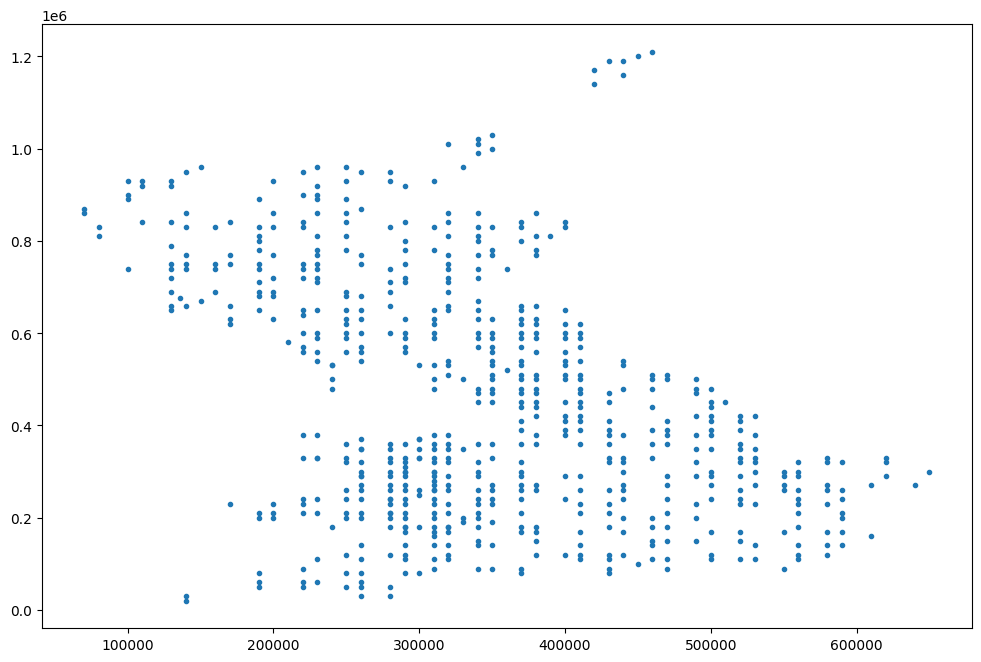

In [34]:
plt.plot(sq_web_codes['E_2_FIG_10KM'],sq_web_codes['N_2_FIG_10KM'],'.')

# Network analysis: correlation of soil moisture squares

Fieldname | Description
---|---
SQUARE | 1km square sampling site code (text)
PLOT | Plot identifier (one of 5 plots within each 1 km square) (number)
YEAR | Year of survey (number)
PH | Fresh soil pH (in water) (number)
LOI | Percentage loss on ignition (number)
C_CONC_LOI | Carbon concentration calculated from loss on ignition (g/kg). Using bespoke CS conversion value for %C calculation of 0.55xLOI. (number)
C_STOCK_LOI | Carbon stock calculated from loss on ignition (t/ha). Using bespoke CS conversion value for %C calculation of 0.55xLOI. (number)
BULK_DENSITY | Bulk density (g/cm3) (number)
MOISTURE | Percentage moisture content (number)
N_PERCENT | Percentage nitrogen (number)
N_STOCK | Nitrogen stock (0-15cm) (t/ha) (number)
PO4_OLSEN | Olsen Phosphorus (mg/kg) (number)
LC07 (text) | ITE Land Class 2007 (Bunce et al., 1996; Bunce et al., 1981, Bunce et al., 2007). 
LC07_NUM (number) | ITE Land Class 2007 (numeric code).
COUNTRY (text) | Country in which 1km square is located (England ENG, Scotland SCO, Wales WAL)
COUNTY07 (text) | County (Eng & Wal) or Council (Sco) in which 1km square is located
EZ_DESC_07 (text) | Countryside Survey Environmental Zone description.  See: https://catalogue.ceh.ac.uk/documents/0cfd454a-d035-416c-80dc-803c65470ea2 

## API request

In [126]:
data = post({
  "metadata": {
      "tags": ["soil"],
      "years": ["2007"]
  },
  "columns": ["MOISTURE","SQUARE","PH","LOI","N_STOCK","PO4_OLSEN","C_CONC_LOI","BULK_DENSITY"]
})
data = data.groupby('SQUARE').mean()
data

,MOISTURE,PH,LOI,N_STOCK,PO4_OLSEN,C_CONC_LOI,BULK_DENSITY
SQUARE,,,,,,,
AAVJXT,29.452936,6.6575,8.191548,NaN,NaN,45.053517,1.078641
ABOBUL,24.075031,6.4780,6.982702,NaN,NaN,38.404862,1.106128
ADHCCF,47.731953,5.3120,15.090771,NaN,NaN,82.999243,0.736132
AHIACC,23.093809,6.5150,4.224647,NaN,NaN,23.235561,1.181468
AHKTWX,18.019368,8.2150,3.894813,4.490414,28.375,21.421474,1.600231
...,...,...,...,...,...,...,...
ZVXGSY,29.130665,6.4600,7.377850,NaN,NaN,40.578175,1.148647
ZWGBOD,72.053203,4.6840,49.660186,NaN,NaN,273.131023,0.320375
ZWKRMA,35.073375,5.3700,7.706792,6.187350,39.200,42.387354,1.016497


### Tips--Finding available fields
Do not specify anything for the `columns` field in the post request. Then type `sorted(data)`


## Correlation between columns

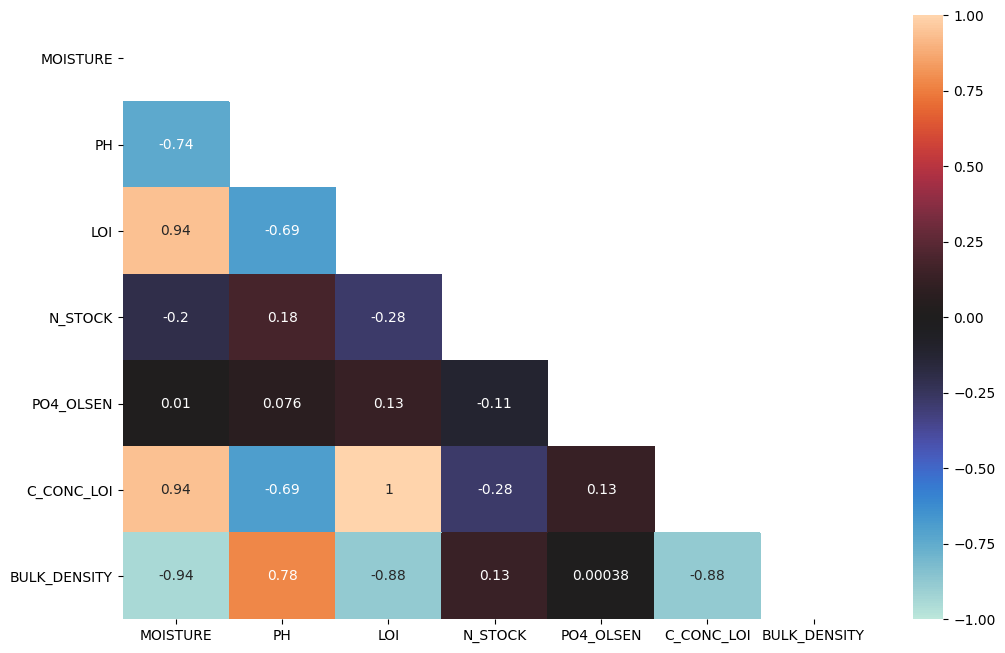

In [41]:

corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center= 0, mask=np.triu(data.corr()))
plt.show()

## Correlation between squares (randomnly pick 40)

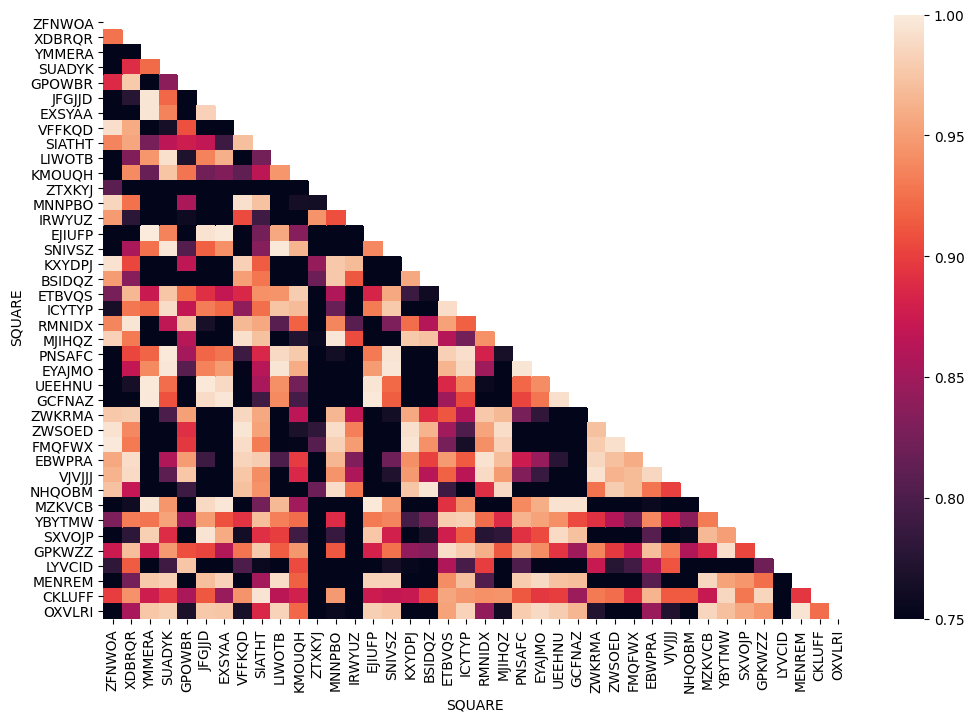

In [153]:
corrMatrix = data.dropna().groupby('SQUARE').mean().sample(n=40).T.corr()
corrMatrix
sn.heatmap(corrMatrix, annot=False,vmin=0.75, vmax=1, mask=np.triu(corrMatrix))
plt.show()

### Draw graph, form edge when correlation > 0.8

{'ZFNWOA': Text(-2.4761207603552355, 55.47289877718146, 'ZFNWOA'),
 'XDBRQR': Text(-0.6245900719093707, 54.118000271318586, 'XDBRQR'),
 'GPOWBR': Text(-1.5567177852280545, 52.77675819484767, 'GPOWBR'),
 'VFFKQD': Text(-1.4180257055543526, 52.056945418245334, 'VFFKQD'),
 'SIATHT': Text(-2.433749719860799, 51.51811703651584, 'SIATHT'),
 'ZTXKYJ': Text(-0.21931986074650967, 52.8541269453407, 'ZTXKYJ'),
 'MNNPBO': Text(-3.717855856474376, 54.92252765689339, 'MNNPBO'),
 'IRWYUZ': Text(0.3596463730422557, 52.57427211219627, 'IRWYUZ'),
 'KXYDPJ': Text(-0.6591501471811462, 53.03970906732352, 'KXYDPJ'),
 'BSIDQZ': Text(-1.4316097921769366, 50.97802730246773, 'BSIDQZ'),
 'ETBVQS': Text(-1.8474914315134983, 54.39537900238636, 'ETBVQS'),
 'RMNIDX': Text(0.3405525240465056, 52.21497157628909, 'RMNIDX'),
 'MJIHQZ': Text(-1.8444210266331609, 55.20415703977096, 'MJIHQZ'),
 'ZWKRMA': Text(-4.549275855971775, 50.68172890308983, 'ZWKRMA'),
 'ZWSOED': Text(-0.6674478135789182, 52.7701032489864, 'ZWSOED'),

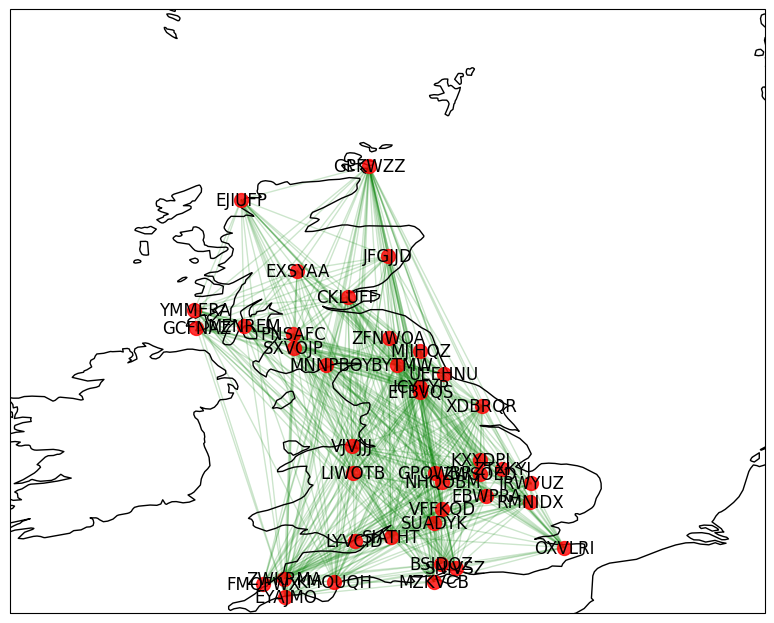

In [154]:
# Turn corrMatrix to (source, receptor, R) data frame then filter R > 0.8
corrMatrix = corrMatrix[corrMatrix > 0.8].unstack().dropna().rename(index={0: "SQUARE1", 1: "SQUARE2", 2: "Pearson"})
corrMatrix = corrMatrix[corrMatrix < 1.00].reset_index(level=1).rename(columns={"SQUARE": "SQUARE2", 0: "Pearson"}).reset_index()


# draw graph
graph = nx.from_pandas_edgelist(corrMatrix, source = "SQUARE", target = "SQUARE2", edge_attr = "Pearson")
mx = sq_web_codes['E_2_FIG_10KM'].values
my = sq_web_codes['N_2_FIG_10KM'].values


pos = {}
for count, elem in enumerate (sq_web_codes['WEB_ID']):
    pos[elem] = (OSGB36toWGS84(mx[count],my[count]))[::-1] 

central_lon, central_lat = 0, 50
extent = [-10, 5, 50, 62]
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extent)
#ax.gridlines()
ax.coastlines(resolution='50m')
nx.draw_networkx_nodes(G = graph, pos = pos,node_list = graph.nodes(),node_color = 'r', alpha = 0.8, node_size = 100) 
nx.draw_networkx_edges(G = graph, pos = pos,edge_color='g', alpha=0.2, arrows = False)
nx.draw_networkx_labels(graph,pos, label_pos =10.3)



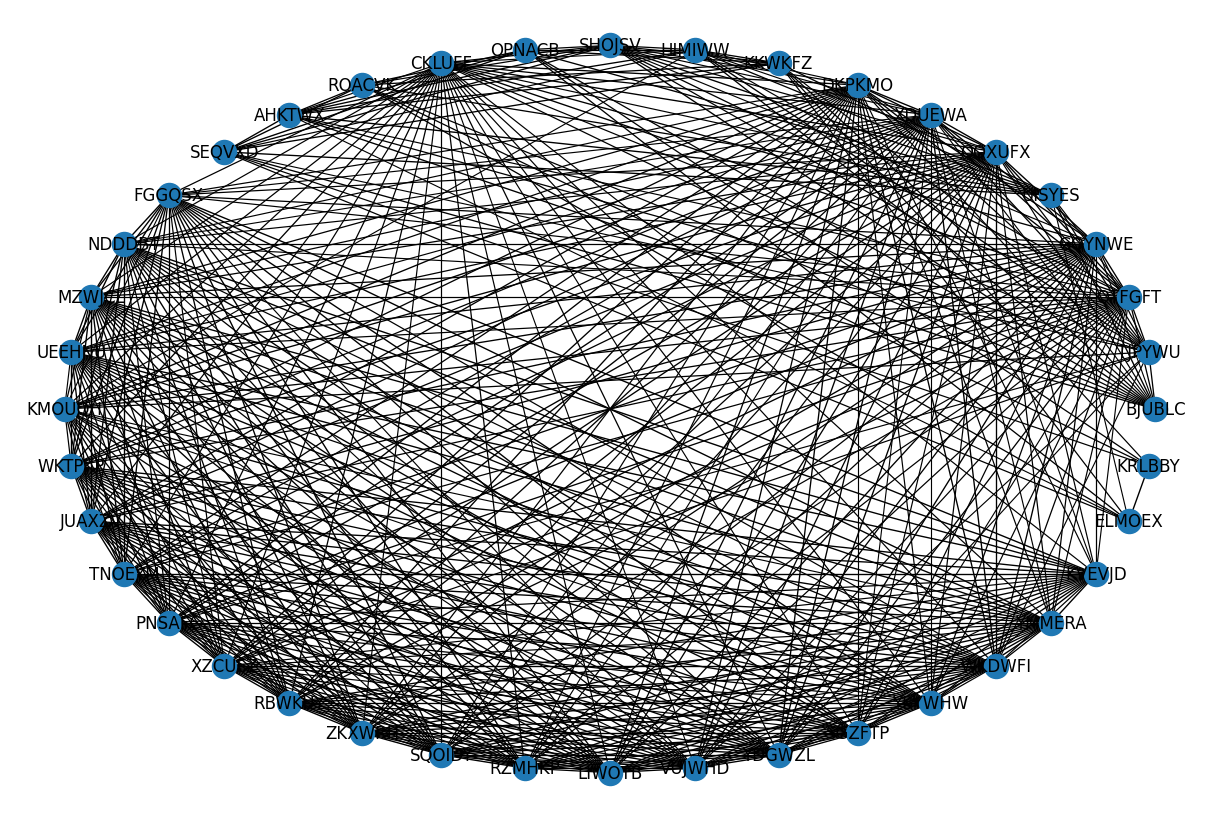

In [51]:
#nx.draw_networkx(graph)
edges = graph.edges()
weights = [graph[u][v]['Pearson'] for u,v in edges]
nx.draw_circular(graph, width=weights,with_labels=True)


# some graph properties

In [90]:
print(nx.clustering(graph, weight=0)) # clustering coefficient
print('Size of graph = '+str(graph.size())) # size of graph, number of edges
#print(nx.shortest_path(graph)) # can specify source and/or target, longest is 5
print('diameter = '+ str(nx.diameter(graph)))

#Betweenness – the number of shortest paths between two nodes going through a specific node or edge

print('average shortest path length = '+ str(nx.average_shortest_path_length(graph)))
print('density of graph length = '+ str(nx.density(graph))) # – ratio of the number of edges to the number of possible edges

# degree centrality, betweeness centrality

{'BJUBLC': 0.6571428571428571, 'TJPYWU': 0.6374269005847953, 'QTFGFT': 0.7386363636363636, 'GQYNWE': 0.8528735632183908, 'UISYES': 0.7424242424242424, 'QQXUFX': 0.8150537634408602, 'XDUEWA': 0.8150537634408602, 'DKPKMO': 0.8150537634408602, 'KKWKFZ': 0.7636363636363637, 'HIMIWW': 0.6813186813186813, 'SHOJSV': 0.6571428571428571, 'QPNACB': 0.8, 'CKLUFF': 0.7386363636363636, 'ROACVK': 0.8333333333333334, 'AHKTWX': 0.7424242424242424, 'SEQVXD': 0.7636363636363637, 'FGGQSX': 0.9886039886039886, 'NDDDBT': 1.0, 'MZWJCL': 0.9886039886039886, 'UEEHNU': 0.9886039886039886, 'KMOUQH': 0.9, 'WKTPKP': 0.9886039886039886, 'JUAXZV': 0.9886039886039886, 'TNOEYM': 0.9886039886039886, 'PNSAFC': 0.9470899470899471, 'XZCUFZ': 0.9470899470899471, 'RBWKUY': 0.9886039886039886, 'ZKXWRH': 0.9886039886039886, 'SQOIDY': 0.9886039886039886, 'RZMHKP': 1.0, 'LIWOTB': 0.9886039886039886, 'VUJWHD': 0.9470899470899471, 'YDGWZL': 0.9470899470899471, 'SGZFTP': 1.0, 'YBYWHW': 0.9886039886039886, 'WKDWFI': 0.947089947089

In [103]:
# mean distance of the shortest path between the node and all the other nodes in the graph
#sorted(nx.closeness_centrality(graph))
{k: v for k, v in sorted(nx.closeness_centrality(graph).items(), reverse=True,key=lambda item: item[1])}

{'QTFGFT': 0.8478260869565217,
 'CKLUFF': 0.8478260869565217,
 'QQXUFX': 0.7959183673469388,
 'XDUEWA': 0.7959183673469388,
 'DKPKMO': 0.7959183673469388,
 'GQYNWE': 0.78,
 'PNSAFC': 0.7222222222222222,
 'XZCUFZ': 0.7222222222222222,
 'VUJWHD': 0.7222222222222222,
 'YDGWZL': 0.7222222222222222,
 'WKDWFI': 0.7222222222222222,
 'KMOUQH': 0.6964285714285714,
 'FGGQSX': 0.6724137931034483,
 'MZWJCL': 0.6724137931034483,
 'UEEHNU': 0.6724137931034483,
 'WKTPKP': 0.6724137931034483,
 'JUAXZV': 0.6724137931034483,
 'TNOEYM': 0.6724137931034483,
 'RBWKUY': 0.6724137931034483,
 'ZKXWRH': 0.6724137931034483,
 'SQOIDY': 0.6724137931034483,
 'LIWOTB': 0.6724137931034483,
 'YBYWHW': 0.6724137931034483,
 'YMMERA': 0.6724137931034483,
 'TJPYWU': 0.6610169491525424,
 'NDDDBT': 0.6610169491525424,
 'RZMHKP': 0.6610169491525424,
 'SGZFTP': 0.6610169491525424,
 'KVEVJD': 0.6610169491525424,
 'BJUBLC': 0.6190476190476191,
 'SHOJSV': 0.6190476190476191,
 'HIMIWW': 0.609375,
 'UISYES': 0.5909090909090909,
 

## degree histogram

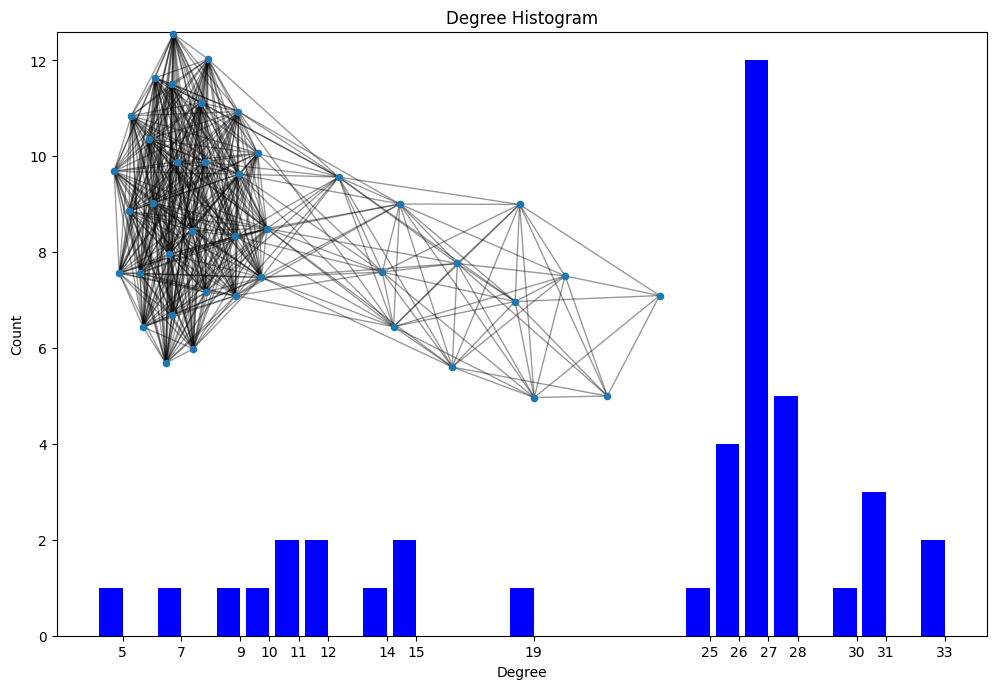

In [87]:
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.15, 0.4, 0.5, 0.5])
Gcc = graph.subgraph(sorted(nx.connected_components(graph), key=len, reverse=True)[0])
pos = nx.spring_layout(graph)
plt.axis("off")
nx.draw_networkx_nodes(graph, pos, node_size=20)
nx.draw_networkx_edges(graph, pos, alpha=0.4)
plt.show()

Text(0.5, 1.0, 'How many other nodes is each node connected to?')

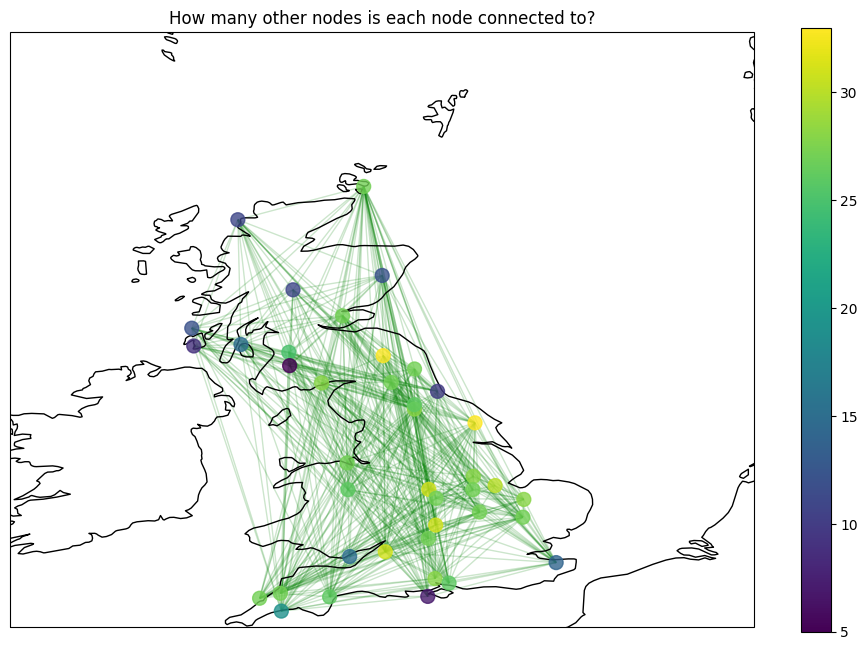

In [158]:
#nx.edge_betweenness_centrality(graph)
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extent)
ax.coastlines(resolution='50m')
nx.draw_networkx_nodes(G = graph, pos = pos,node_list = graph.nodes(),node_color = degree_sequence, alpha = 0.8, node_size = 100) 
nx.draw_networkx_edges(G = graph, pos = pos,edge_color='g', alpha=0.2, arrows = False)
#nx.draw_networkx_labels(graph,pos, label_pos =10.3)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = min(degree_sequence), vmax=max(degree_sequence)))

plt.colorbar(sm)
plt.title('How many other nodes is each node connected to?')

# adjacency matrix

In [104]:
a = nx.to_numpy_matrix(graph)

#plt.imshow(a, cmap='Greys', interpolation='nearest')
#plt.colorbar()


### Table： Summary of key graph properties using different four different thresholds.

Graph property | Threshold
--- | ---
 |0.6 0.7 0.8 0.9
No. nodes | 801 801 801 801
No. edges | 50,550 21,186 6,781 1,170
Diameter | 7 9 18 15
Average path length | 2.45 3.46 5.86 4.18
Max. Degree | 317 161 56 18
Mean degree | 126.22 52.90 16.93 2.92
No. of stations with 0 degree | 6 10 25 191
Clustering coefficient | 0.61 0.57 0.57 0.54
Graph density | 0.16 0.07 0.02 0.00


Future work:
- community detection
- Which square has the highest and lower degree centrality (most and fewest connected edges)?
## do some micro-analysis of the above results (e.g. what is the most central plot？）

# Community detection 
### (aka clsuter analysis/graph partitioning): can we explain node connectivity behaviour?

In [136]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(graph)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

In [139]:
top_level_communities


({'AHKTWX',
  'AKYQNY',
  'ANHJGW',
  'AQLJEH',
  'AUMEYK',
  'BBIJIG',
  'BHNAKW',
  'BJUBLC',
  'BQBGBD',
  'BSIDQZ',
  'BUITKA',
  'CDHIYE',
  'CHQQXO',
  'CIOSPC',
  'CIPHOQ',
  'CKLUFF',
  'CLLBKV',
  'CMBROG',
  'COIKIP',
  'DEJBBK',
  'DKFVKM',
  'DKPKMO',
  'DKUMUJ',
  'DTXAJY',
  'DWPADG',
  'DZIAED',
  'DZKTFU',
  'EARTZW',
  'EBPSDO',
  'EBWPRA',
  'EIKMDF',
  'EJIUFP',
  'ELMOEX',
  'ELWJGA',
  'EPDZLB',
  'ERZTLR',
  'ETBBOE',
  'ETBVQS',
  'EXSYAA',
  'EYAJMO',
  'FAQWDV',
  'FBUJKB',
  'FBWAHU',
  'FGGQSX',
  'FMFSCG',
  'FMQFWX',
  'FNQTOM',
  'FOXCNS',
  'GCDFIO',
  'GCFNAZ',
  'GCKECU',
  'GKPUAI',
  'GNSZNY',
  'GPKWZZ',
  'GPOWBR',
  'GQYNWE',
  'GUBASC',
  'GXZDXP',
  'HAWCOO',
  'HCFYIX',
  'HGBYWJ',
  'HGUOAH',
  'HHGYVR',
  'HHNXYQ',
  'HIMIWW',
  'HLPOPT',
  'HPLWER',
  'HYILAM',
  'HZXYKQ',
  'ICYTYP',
  'IDAVFQ',
  'IPLMTS',
  'IRWYUZ',
  'JABGJY',
  'JBIYLU',
  'JDKZQA',
  'JDUTQQ',
  'JFGJJD',
  'JFYGIL',
  'JKBXAQ',
  'JUAXZV',
  'KBLGPE',
  'KFACFB',
  'K

In [140]:
from networkx.algorithms import bipartite
bipartite.spectral_bipartivity(graph)


0.5

# minimum viable network/ optimized network

warning: this is dyanmically changing and is affected the selected variables

# all data

In [141]:

corrMatrix = data.dropna().groupby('SQUARE').mean().T.corr()
# Turn corrMatrix to (source, receptor, R) data frame then filter R > 0.8
corrMatrix = corrMatrix[corrMatrix > 0.8].unstack().dropna().rename(index={0: "SQUARE1", 1: "SQUARE2", 2: "Pearson"})
corrMatrix = corrMatrix[corrMatrix < 1.00].reset_index(level=1).rename(columns={"SQUARE": "SQUARE2", 0: "Pearson"}).reset_index()


# draw graph
graph = nx.from_pandas_edgelist(corrMatrix, source = "SQUARE", target = "SQUARE2", edge_attr = "Pearson")
print(nx.clustering(graph, weight=0)) # clustering coefficient


{'AHKTWX': 0.838375350140056, 'BHNAKW': 0.7700581907952742, 'BJUBLC': 0.8176546391752577, 'BQBGBD': 0.8484848484848485, 'BSIDQZ': 0.8528399311531841, 'CHQQXO': 0.6836635586635587, 'CKLUFF': 0.7005492071928426, 'COIKIP': 0.6821002776416789, 'DKFVKM': 0.9862068965517241, 'DKUMUJ': 0.8348516015280635, 'DZIAED': 0.6860383206537053, 'EBPSDO': 0.6971631205673758, 'EBWPRA': 0.6995961784694179, 'ELMOEX': 0.9798387096774194, 'EPDZLB': 0.7898343803540834, 'ERZTLR': 0.6805726189840287, 'FAQWDV': 0.687526835551739, 'FMQFWX': 0.8094298245614036, 'FNQTOM': 0.8177278401997503, 'GCKECU': 0.705412907702984, 'GPKWZZ': 0.7035609885729471, 'GPOWBR': 0.7647597254004577, 'GUBASC': 0.7763932156455521, 'HCFYIX': 0.8153508771929825, 'HGBYWJ': 0.831899024670109, 'HIMIWW': 0.8490073145245559, 'HLPOPT': 0.8422260470453241, 'HYILAM': 0.7588495575221239, 'IDAVFQ': 0.896351136964569, 'IPLMTS': 0.6996182703698829, 'IRWYUZ': 0.8696177062374245, 'JBIYLU': 0.6995662752565324, 'JDKZQA': 0.8439873417721518, 'JDUTQQ': 0.96

In [119]:
x = nx.clustering(graph, weight=0)
{k: v for k, v in sorted(x.items(), key=lambda item: item[1])}


{'ERZTLR': 0.6805726189840287,
 'SIATHT': 0.6818156502367029,
 'COIKIP': 0.6821002776416789,
 'CHQQXO': 0.6836635586635587,
 'DZIAED': 0.6860383206537053,
 'FAQWDV': 0.687526835551739,
 'QTFGFT': 0.6956313844816344,
 'EBPSDO': 0.6971631205673758,
 'JBIYLU': 0.6995662752565324,
 'EBWPRA': 0.6995961784694179,
 'IPLMTS': 0.6996182703698829,
 'RZPWIO': 0.6999043519846964,
 'CKLUFF': 0.7005492071928426,
 'NYVXXI': 0.700795978215333,
 'GPKWZZ': 0.7035609885729471,
 'GCKECU': 0.705412907702984,
 'MJNWTN': 0.7068224952552192,
 'QERSLS': 0.708678065820923,
 'YGQIJY': 0.7097902097902098,
 'XDBRQR': 0.7111198660494435,
 'RMNIDX': 0.7157578359811078,
 'KMXNYL': 0.7168954649858448,
 'VGSKFD': 0.728158980127484,
 'EIKMDF': 0.7283429482669669,
 'DKPKMO': 0.7287650673045354,
 'QQXUFX': 0.7287650673045354,
 'KZHPIL': 0.7298898071625345,
 'NBXWRU': 0.7331754676770069,
 'TKHLXB': 0.7382827146606674,
 'YBYTMW': 0.7457932985416769,
 'OOLGBN': 0.7462810320440911,
 'ZUJTKP': 0.7464761254450568,
 'ETBVQS': 0.